In [ ]:
# default_exp data

# Dataset Management
> Some convenience functions for getting data to play with

These are some datasets I used while making and testing all this. This code should make it fairly easy to change between them. Hopefully the examples here are enough that you could adapt one to any other dataset you want to try.

### CelebA

Celebrity faces. A useful test dataset since they're roughly aligned and thus easier to generate.

In [ ]:
#export 
from PIL import Image
import numpy as np
def tensor_to_image(t):
    return Image.fromarray(np.array(((t.detach().cpu().squeeze().permute(1, 2, 0)+1)/2).clip(0, 1)*255).astype(np.uint8))

In [ ]:
#export
from datasets import load_dataset
from torchvision import transforms as T
from torch.utils.data import Dataset, DataLoader

class CelebADataset(Dataset):
    """One option: custom Dataset class"""
    def __init__(self, img_size=128):
        self.dataset = load_dataset('huggan/CelebA-faces')['train']
        self.preprocess = T.Compose([T.ToTensor(),T.Resize(img_size), T.CenterCrop(img_size)])
    def __len__(self):
        return len(self.dataset)
    def __getitem__(self, idx):
        x = self.dataset[idx]
        return (self.preprocess(x['image']), 'A photo of a face')
        
def get_celebA_dl(img_size=128, batch_size=32):
    dataset = CelebADataset(img_size)
    dl = DataLoader(dataset, batch_size=batch_size)
    return dl

And in action:

Using custom data configuration huggan--CelebA-faces-8a807f0d7d4912ca
Reusing dataset parquet (/root/.cache/huggingface/datasets/parquet/huggan--CelebA-faces-8a807f0d7d4912ca/0.0.0/0b6d5799bb726b24ad7fc7be720c170d8e497f575d02d47537de9a5bac074901)


  0%|          | 0/1 [00:00<?, ?it/s]

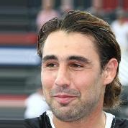

In [ ]:
#slow_test
dl = get_celebA_dl()
images, texts = next(iter(dl))
tensor_to_image(images[0]*2-1)

### Conceptual Captions 12M

These actually have text associated with the images. Useful for text-to-image testing and so on. I've been meaning to do LAION as well but for now this works.

In [ ]:
#export
import webdataset as wds
import torch
def get_cc12m_dl(img_size=128, batch_size=32,url=None, num_workers=8):
    if url == None:
        url = 'https://huggingface.co/datasets/laion/conceptual-captions-12m-webdataset/resolve/main/data/{00000..01200}.tar'
    preproc = T.Compose([T.ToTensor(),T.Resize(img_size), T.CenterCrop(img_size)])
    dataset = (
          wds.WebDataset(url)
          .shuffle(1000)
          .decode("pil")
          .rename(image="jpg;png", text="txt")
          .map_dict(image=preproc)
          .to_tuple("image", "text")
    )
    dl = torch.utils.data.DataLoader(dataset, batch_size=batch_size, num_workers=num_workers)
    return dl

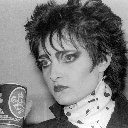

In [ ]:
#slow_test
dl = get_cc12m_dl()
images, texts = next(iter(dl))
tensor_to_image(images[0]*2-1)

### Paired VQGAN reconstructions

I also tried an image repair task, that requires a low quality image and a high quality version. The 'Low quality version' is a 256px image that has been encoded then decoded with VQGAN. The target is the 512px reference image.

In [ ]:
#export
def get_paired_vqgan(batch_size=32):
    preprocess_image = T.Compose([
        T.ToTensor(),
    ])
    def preprocess(sample):
        return {
            "decoded": preprocess_image(sample["decoded.jpg"]),
            "input": preprocess_image(sample["input.jpg"])
        }
    urls = 'https://huggingface.co/datasets/dalle-mini/vqgan-pairs/resolve/main/data/{00001..00954}.tar'
    dataset = (wds.WebDataset(urls, handler=wds.warn_and_continue)
               .shuffle(2500)
               .decode("pil")
               .map(preprocess)
               .to_tuple("decoded", "input")
               .batched(batch_size))

    dl = wds.WebLoader(
        dataset,
        batch_size=None,
        num_workers=2
    )
    dl = dl.unbatched().batched(batch_size)
    return dl

torch.Size([32, 3, 256, 256]) torch.Size([32, 3, 512, 512])


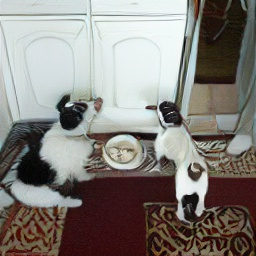

In [ ]:
#slow_test
dl = get_paired_vqgan()
lq, hq = next(iter(dl))
print(lq.shape, hq.shape)
tensor_to_image(lq[0]*2-1)